# 1. Environment

In [1]:
# Test environment
import torch; print('PyTorch:', torch.__version__, 'CUDA:', torch.cuda.is_available())
if torch.cuda.is_available() :
    print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

PyTorch: 2.4.1+cpu CUDA: False
device : cpu


In [2]:
from matcha.models.matcha_tts import MatchaTTS; print('MatchaTTS OK')
from phonemizer import phonemize; print('Phonemizer OK')

MatchaTTS OK
Phonemizer OK


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import soundfile as sf
import IPython.display as ipd
import whisper
import jiwer
from pathlib import Path

# Import Matcha components
from matcha.models.matcha_tts import MatchaTTS
from matcha.text import text_to_sequence
from matcha.utils.utils import intersperse
from matcha.hifigan.models import Generator as HiFiGAN
from matcha.hifigan.config import v1
from matcha.hifigan.env import AttrDict
from matcha.hifigan.denoiser import Denoiser


# This allows for real time code changes being reflected in the notebook, no need to restart the kernel
%load_ext autoreload
%autoreload 2
%matplotlib inline


# 2. Load Models

In [4]:
# 1. matcha-tts model
MATCHA_CHECKPOINT = r"models\matcha_ljspeech.ckpt"

In [5]:
def load_model(checkpoint_path):
    model = MatchaTTS.load_from_checkpoint(checkpoint_path, map_location=device)
    model.eval()
    return model

model = load_model(MATCHA_CHECKPOINT)
print(f"Model loaded!")

d:\Work Life\Studies\M2 ISI\S1\2 - Machine learning avancé\MLA Projet\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\lightning\fabric\utilities\cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

Model loaded!


In [6]:
# 2. Vocoder (Mel-spectrograms -> Audio)
VOCODER_PATH = r"vocoders\hifigan_T2_v1"

In [7]:
def load_vocoder(checkpoint_path):
    h = AttrDict(v1)
    hifigan = HiFiGAN(h).to(device)
    hifigan.load_state_dict(torch.load(checkpoint_path, map_location=device)['generator'])
    _ = hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

vocoder = load_vocoder(VOCODER_PATH)
denoiser = Denoiser(vocoder, mode='zeros')

d:\Work Life\Studies\M2 ISI\S1\2 - Machine learning avancé\MLA Projet\MatchaTTS-Implementation-Analysis\.venv\lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\adjal\AppData\Local\Temp\ipykernel_22768\2714889153.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the

Removing weight norm...


# 3. Run Inference

In [8]:
text_input = "Hello world"

In [9]:
# 1. Text processing

@torch.inference_mode()
def process_text(text, device):
    
    # a. Convert text to phoneme IDs
    # 'english_cleaners2' handles number expansion and phonemization via espeak
    sequence = text_to_sequence(text, ['english_cleaners2'])[0]
    
    # b. Intersperse with '0' (blank token) for the flow matching stability
    sequence = intersperse(sequence, 0)
    
    # c. Convert to tensor
    x = torch.tensor(sequence, dtype=torch.long, device=device)[None] # Add batch dim

    # metadatas
    x_lengths = torch.tensor([x.shape[-1]], dtype=torch.long, device=device)

    # output
    output = {
        'text': text,
        'x': x,
        'x_lengths': x_lengths
    }
    
    return output

In [10]:
processed_text = process_text(text_input, device)
print(f"model input 1 (phonems sequence IDs) : {processed_text['x']}, shape : {processed_text['x'].shape}")
print(f"model input 2 (processed sequence length) : {processed_text['x_lengths']}")

model input 1 (phonems sequence IDs) : tensor([[  0,  50,   0,  83,   0,  54,   0, 156,   0,  57,   0, 135,   0,  16,
           0,  65,   0, 156,   0,  87,   0, 158,   0,  54,   0,  46,   0]]), shape : torch.Size([1, 27])
model input 2 (processed sequence length) : tensor([27])


In [11]:
# 2. run synthesis with model

@torch.inference_mode()
def run_model(
    processed_text, 
    model,
    n_timesteps,
    length_scale,
    temperature,
    spks
    ) :

    """
    output dictionarry : 
        output = {
        "mel": Tensor,
        "mel_lengths": Tensor,
        "wav": Tensor,
        "durations": Tensor,
        "attn": Tensor,
        "noise": Tensor,
        "x_mask": Tensor,
        "y_mask": Tensor,
        "inference_duration": float (s),
        "x": Tensor,
        "x_lengths": Tensor,
        "text": str,
        "phones": list[str],
    }

    """

    # log start
    t_start = dt.datetime.now()

    # start inference
    output = model.synthesise(
        processed_text['x'], 
        processed_text['x_lengths'],
        n_timesteps=n_timesteps,
        length_scale=length_scale,
        temperature=temperature,
        spks=spks
        
    )

    # log end
    t_end = dt.datetime.now()
    inference_duration = (t_end - t_start).total_seconds()

    # merge everything to one dict    
    output.update({'inference_duration': inference_duration, **processed_text})

    # print time
    print(f"Inference completed ! Duration : {inference_duration} s")

    return output

Inference completed ! Duration : 0.341876 s
Generated Mel Shape: torch.Size([1, 80, 80])


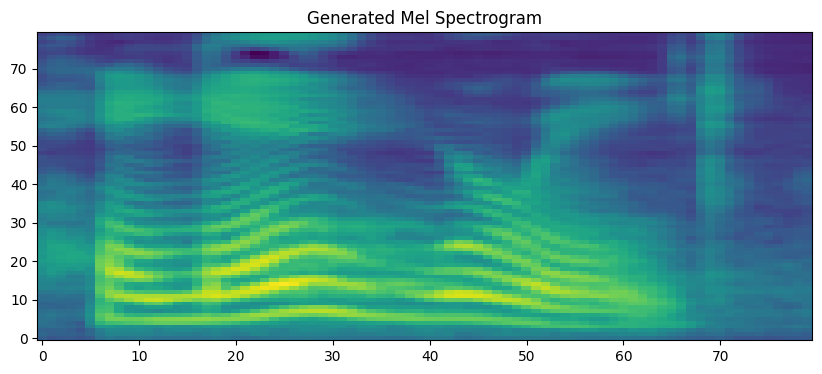

In [12]:
n_timesteps = 10
length_scale = 1
temperature = 0.667
spks = None

output = run_model(
    processed_text, 
    model,
    n_timesteps,
    length_scale,
    temperature,
    spks
    )

mel = output['mel']
print(f"Generated Mel Shape: {mel.shape}")

# Visualisation

plt.figure(figsize=(10, 4))
plt.imshow(mel.squeeze().cpu().numpy(), origin='lower', aspect='auto')
plt.title("Generated Mel Spectrogram")
plt.show()

In [13]:
# 3. Generate audio from mel

@torch.inference_mode()
def to_waveform(mel, vocoder, denoiser_strength):
    audio = vocoder(mel).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), strength=denoiser_strength).cpu().squeeze()
    return audio.cpu().squeeze()

def save_to_folder(filename: str, output: dict, folder: str, output_audio_sr: int):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)
    np.save(folder / f'{filename}', output['mel'].cpu().numpy())
    sf.write(folder / f'{filename}.wav', output['waveform'], output_audio_sr, 'PCM_24')

    output_audio_path = str(folder) + "/" + filename + ".wav"
    print(f"Mel and Audio saved in '{output_audio_path}'")

    return output_audio_path
    


In [14]:
denoiser_strength = 0.00025
output_audio_sr = 22050

output['waveform'] = to_waveform(output['mel'], vocoder, denoiser_strength)

## Display the synthesised waveform
ipd.display(ipd.Audio(output['waveform'], rate=output_audio_sr))

In [15]:
filename = "matchatts_output"
output_folder = "audios"

output_audio_path = save_to_folder(filename, output, output_folder, output_audio_sr)


Mel and Audio saved in 'audios/matchatts_output.wav'


# 4. Metrics

Based on the Matcha-TTS paper, the authors utilized four primary categories of evaluation metrics: **Efficiency (Memory/Params)**, **Speed (RTF)**, **Intelligibility (WER)**, And **Naturalness (MOS)**.

---


### 1. Parameter count

**Type:** Objective (Resource Usage)

* **Definition:** The number of trainable weights in the neural network.
* **Rationale:** To demonstrate that the model is lightweight enough for edge devices.
* **Paper Implementation:** Comparing counts against Grad-TTS and VITS.


### 2. Memory Footprint (RAM)

**Type:** Objective (Resource Usage)

* **Definition:** How much memory usage : more than parameter count - it's the main limiter on how large and powerful models that can be trained.
* **Rationale:** To demonstrate that the model is lightweight enough for edge devices.
* **Paper Implementation:** Comparing counts against Grad-TTS and VITS.


### 3. Real-Time Factor (RTF)

**Type:** Objective (Speed/Latency)

* **Definition:** The time it takes to generate the audio divided by the duration of the generated audio.
* **Formula:** RTF = Time to Synthesize (seconds)​ / Duration of Audio (seconds)

* **Interpretation:**
* RTF < 1 : Faster than real-time (Good).
* RTF = 0.01 : It takes 1 second to generate 100 seconds of audio.


* **Rationale:** The main selling point of Matcha-TTS is speed.
* **Paper Implementation:** Measured on a single NVIDIA A100 GPU and Intel Xeon CPUs. They measured strictly the *mel-spectrogram generation* time (excluding the vocoder in some comparisons, though usually, total synthesis is preferred for end-users).


### 4. Word Error Rate (WER)

**Type:** Objective (Intelligibility)

* **Definition:** The percentage of words that an Automatic Speech Recognition (ASR) system fails to transcribe correctly from the generated audio compared to the input text.
* **Formula:** WER = (Substitutions+Deletions+Insertions) / N

Where:
*  Substitutions : (wrong words)
*  Deletions : (missed words)
*  Insertions : (extra words)
*  N : Total number of words in the reference text.


* **Rationale:** A TTS model might sound "natural" (good tone) but mumble or skip words. WER ensures the model is actually speaking the correct text.
* **Paper Implementation:** The authors used OpenAI's **Whisper (medium)** model to transcribe the generated audio.


### 5. Mean Opinion Score (MOS)

**Type:** Subjective (Human Evaluation)

* **Definition:** The arithmetic mean of ratings given by human listeners on the perceived quality of the speech.
* **Scale:** 1 (Bad) to 5 (Excellent).
* **Rationale:** Objective metrics often fail to capture the nuances of human speech prosody and emotion. MOS is considered the "gold standard" for TTS quality.
* **Paper Implementation:** They used the "Prolific" crowdsourcing platform with paid native English speakers. They filtered out listeners who failed "attention checks" (fake samples).


### Summary Mertrics

| Metric | Tool/Library | Target Value (Matcha) |
| --- | --- | --- |
| **Params** | PyTorch internal | ~18M (Small) |
| **RAM** | PyTorch internal | ~4.8 (Small) |
| **RTF** | `time`, `torch.cuda` | ~0.01 (Very Low) |
| **WER** | `whisper`, `jiwer` | ~2.5% (Low) |
| **MOS** | `speechmos` (or Humans) | ~3.84 (High) |

In [16]:
# parameters count

count_params = lambda x: f"{sum(p.numel() for p in x.parameters()):,}"

print(f"Parameter count: {count_params(model)}")

Parameter count: 18,204,193


In [17]:
# Memory Footprint (RAM)

In [18]:
# Real-Time Factor (RTF)

rtf_w = output['inference_duration'] / (output['waveform'].shape[-1]/output_audio_sr)

print(f"rtf : {rtf_w}")

rtf : 0.368084267578125


In [23]:
# Word Error Rate (WER) - (objective metric)

# Load ASR Model (Use 'medium' as per the paper)
asr_model = whisper.load_model("medium")

# Run Metric calculation
def calculate_wer(reference_text, generated_audio_path):
    result = asr_model.transcribe(str(generated_audio_path))
    hypothesis_text = result["text"]

    # Preprocess manually
    def clean(text):
        text = text.lower()
        text = jiwer.RemovePunctuation()(text)
        text = jiwer.RemoveMultipleSpaces()(text)
        text = jiwer.Strip()(text)
        return text

    reference_text = clean(reference_text)
    hypothesis_text = clean(hypothesis_text)

    wer_score = jiwer.wer(reference_text, hypothesis_text)

    print(f"Reference (cleaned) : '{reference_text}'")
    print(f"Hypothesis (cleaned) : '{hypothesis_text}'")
    print(f"WER        : {wer_score:.4f}")

    return wer_score, hypothesis_text

# Usage
score, trans = calculate_wer(output['text'], output_audio_path)
print(f"WER: {score:.4f} (Transcribed: {trans})")

Reference (cleaned) : 'hello world'
Hypothesis (cleaned) : 'hello world'
WER        : 0.0000
WER: 0.0000 (Transcribed: hello world)


In [ ]:
# Mean Opinion Score (MOS) - (subjective metric)